Initialisation du projet

In [1]:
# =========================
# CELL 1 - INITIALISATION
# Import des librairies et variables globales
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from math import sqrt
from scipy import stats
from matplotlib.backends.backend_pdf import PdfPages
from tabulate import tabulate

# Fixe un seed pour reproductibilité
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Variables
INPUT_CSV = "events.csv"   # Fichier CSV dans le même dossier que le notebook
ALPHA = 0.05

# Style seaborn pour graphiques
sns.set_style("whitegrid")


Chargement des données et exploration

In [2]:
# =========================
# CELL 2 - CHARGEMENT & EXPLORATION
# =========================
df = pd.read_csv(INPUT_CSV)

# Aperçu général
print("Colonnes :", df.columns.tolist())
print("Types d'événements :", df['event'].unique())
print("Nombre total d'événements :", len(df))
print("Proportion des événements :\n", df['event'].value_counts(normalize=True))
print("Visiteurs uniques :", df['visitorid'].nunique())


Colonnes : ['timestamp', 'visitorid', 'event', 'itemid', 'transactionid']
Types d'événements : ['view' 'addtocart' 'transaction']
Nombre total d'événements : 2756101
Proportion des événements :
 event
view           0.966696
addtocart      0.025156
transaction    0.008148
Name: proportion, dtype: float64
Visiteurs uniques : 1407580


Nettoyage & filtrage

In [3]:
# =========================
# CELL 3 - NETTOYAGE & FILTRAGE
# =========================
df = df[df['event'].isin(['view','addtocart'])].copy()

# Vérification valeurs manquantes
print("Valeurs manquantes :\n", df.isna().sum())

# Nombre d'événements par type
print("Événements par type :\n", df['event'].value_counts())


Valeurs manquantes :
 timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64
Événements par type :
 event
view         2664312
addtocart      69332
Name: count, dtype: int64


Simulation A/B Test

In [4]:
# =========================
# CELL 4 - SIMULATION A/B TEST
# =========================
unique_visitors = df['visitorid'].unique()
np.random.seed(RANDOM_SEED)
groups = np.random.choice(['A','B'], size=len(unique_visitors))
visitor_group = pd.DataFrame({'visitorid': unique_visitors, 'group': groups})

df = df.merge(visitor_group, on='visitorid', how='left')

# Vérification répartition
print(df['group'].value_counts(normalize=True))


group
B    0.501302
A    0.498698
Name: proportion, dtype: float64


Calcul du KPI Add-to-Cart Rate

In [5]:
# =========================
# CELL 5 - CALCUL KPI ADD-TO-CART RATE
# =========================
kpi = df.groupby(['group','event']).size().unstack(fill_value=0)
kpi['add_to_cart_rate'] = kpi['addtocart'] / kpi['view']
diff_points = (kpi.loc['B','add_to_cart_rate'] - kpi.loc['A','add_to_cart_rate'])*100

print("KPI par groupe :\n", kpi)
print(f"Différence B - A : {diff_points:.2f} points %")


KPI par groupe :
 event  addtocart     view  add_to_cart_rate
group                                      
A          35121  1328142          0.026444
B          34211  1336170          0.025604
Différence B - A : -0.08 points %


Test statistique de proportion

In [6]:
# =========================
# CELL 6 - TEST STATISTIQUE
# =========================
n_a = kpi.loc['A','view']
n_b = kpi.loc['B','view']
p_a = kpi.loc['A','add_to_cart_rate']
p_b = kpi.loc['B','add_to_cart_rate']

# Pooled proportion
p_pool = (p_a*n_a + p_b*n_b) / (n_a + n_b)

# Z-score
z = (p_a - p_b) / sqrt(p_pool*(1-p_pool)*(1/n_a + 1/n_b))

# p-value bilatérale
p_value = 2 * (1 - stats.norm.cdf(abs(z)))

print(f"Z-score : {z:.4f}")
print(f"P-value : {p_value:.4f}")

if p_value < ALPHA:
    print("Différence significative au niveau α =", ALPHA)
else:
    print("Pas de différence significative au niveau α =", ALPHA)


Z-score : 4.3058
P-value : 0.0000
Différence significative au niveau α = 0.05


Analyse Business

In [7]:
# =========================
# CELL 7 - ANALYSE BUSINESS
# =========================
print("Analyse business :")
print(f"Add-to-cart rate A : {p_a:.4f}, B : {p_b:.4f}")
print(f"Différence : {diff_points:.2f} points %")
if p_value < ALPHA:
    if p_b > p_a:
        print("B est significativement meilleur → recommander B en production")
    else:
        print("A est significativement meilleur → garder A")
else:
    print("Aucune différence significative → tester éventuellement une variante C")


Analyse business :
Add-to-cart rate A : 0.0264, B : 0.0256
Différence : -0.08 points %
A est significativement meilleur → garder A


Graphiques professionnels

C:\Users\samir\AppData\Local\Temp\ipykernel_2308\1190800737.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=kpi.index, y=kpi['add_to_cart_rate']*100, palette=['#3498db','#2ecc71'])


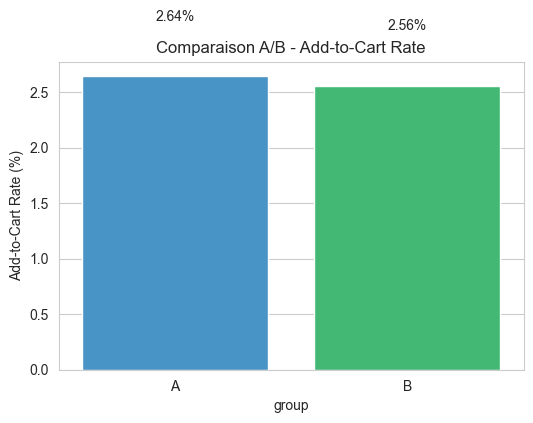

╒═════════╤═════════════╤═════════════╤════════════════════╕
│ group   │        view │   addtocart │   add_to_cart_rate │
╞═════════╪═════════════╪═════════════╪════════════════════╡
│ A       │ 1.32814e+06 │       35121 │               2.64 │
├─────────┼─────────────┼─────────────┼────────────────────┤
│ B       │ 1.33617e+06 │       34211 │               2.56 │
╘═════════╧═════════════╧═════════════╧════════════════════╛


In [8]:
# =========================
# CELL 8 - VISUALISATIONS PRO
# =========================

# Barplot Add-to-Cart Rate
plt.figure(figsize=(6,4))
sns.barplot(x=kpi.index, y=kpi['add_to_cart_rate']*100, palette=['#3498db','#2ecc71'])
plt.ylabel("Add-to-Cart Rate (%)")
plt.title("Comparaison A/B - Add-to-Cart Rate")
for i, v in enumerate(kpi['add_to_cart_rate']*100):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center')
plt.show()

# Tableau résumé avec tabulate
summary = kpi[['view','addtocart','add_to_cart_rate']].copy()
summary['add_to_cart_rate'] = (summary['add_to_cart_rate']*100).round(2)
print(tabulate(summary, headers='keys', tablefmt='fancy_grid'))


Export PDF / Mini-Rapport

In [9]:
# =========================
# CELL 9 - EXPORT PDF PROFESSIONNEL
# =========================
with PdfPages('TP4_report_pro.pdf') as pdf:
    # Barplot KPI
    fig, ax = plt.subplots(figsize=(6,4))
    sns.barplot(x=kpi.index, y=kpi['add_to_cart_rate']*100, palette=['#3498db','#2ecc71'], ax=ax)
    ax.set_ylabel("Add-to-Cart Rate (%)")
    ax.set_title("Comparaison A/B - Add-to-Cart Rate")
    for i, v in enumerate(kpi['add_to_cart_rate']*100):
        ax.text(i, v + 0.5, f"{v:.2f}%", ha='center')
    pdf.savefig(fig)
    plt.close()

    # Tableau résumé
    fig, ax = plt.subplots(figsize=(6,2))
    ax.axis('tight')
    ax.axis('off')
    table_data = [[idx] + list(row) for idx,row in summary.iterrows()]
    table = ax.table(cellText=table_data, colLabels=["Groupe","Views","Add-to-Cart","Add-to-Cart Rate (%)"], loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1,1.5)
    pdf.savefig(fig)
    plt.close()
    
print("Rapport PDF professionnel généré : TP4_report_pro.pdf")


Rapport PDF professionnel généré : TP4_report_pro.pdf


C:\Users\samir\AppData\Local\Temp\ipykernel_2308\3230305739.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=kpi.index, y=kpi['add_to_cart_rate']*100, palette=['#3498db','#2ecc71'], ax=ax)
